In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.colors import LogNorm
from scipy import ndimage
import pandas as pd
import datetime
from windrose import WindroseAxes
import geopy.distance as gpd

In [2]:
Buoy = 'E05'
lidarE05 = xr.open_dataset("LiDAR/"+Buoy+"_lidar_full.nc").isel(t=slice(2880, 107868)) # 2019-09-04 through 2021-09-04
jet_idE05 = xr.open_dataset('LiDAR/full_'+Buoy+'_LLJs.nc').isel(t=slice(2880, 107868))

In [3]:
Buoy = 'E06'
lidarE06 = xr.open_dataset("LiDAR/"+Buoy+"_lidar_full.nc").isel(t=slice(0, 103777))
jet_idE06 = xr.open_dataset('LiDAR/full_'+Buoy+'_LLJs.nc').isel(t=slice(0, 103777))

In [4]:
# Overall jet statistics
print('Overall frequencies (E06, E05): ', jet_idE06['is_jet'].sum().data/len(jet_idE06['is_jet']), jet_idE05['is_jet'].sum().data/len(jet_idE05['is_jet']))
print('Jets out of valid data (E06, E05): ', jet_idE06['is_jet'].sum().data/jet_idE06['is_valid'].sum().data, jet_idE05['is_jet'].sum().data/jet_idE05['is_valid'].sum().data) 

Overall frequencies (E06, E05):  0.026903841891748652 0.02804129995809045
Jets out of valid data (E06, E05):  0.03467849113785694 0.02862170544142953


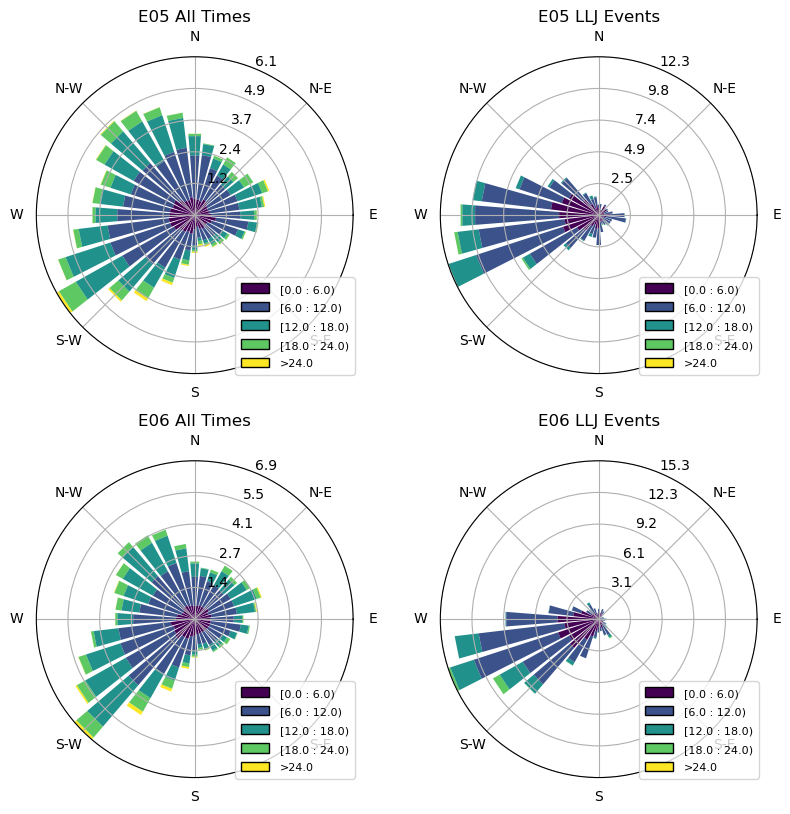

In [5]:
# Windrose Plots
fig = plt.figure(constrained_layout=True, figsize=(8,8))
subfigs = fig.subfigures(2, 2)

all_ws = lidarE06['windspeed'].isel(z=7)
all_wd = lidarE06['winddirection'].isel(z=7)

jet_ws = lidarE06['windspeed'].isel(z=7).data[jet_idE06['is_jet'].data]
jet_wd = lidarE06['winddirection'].isel(z=7).data[jet_idE06['is_jet'].data]

ax = WindroseAxes.from_ax(fig=subfigs[0][0])
ax.bar(lidarE05['winddirection'].isel(z=7), lidarE05['windspeed'].isel(z=7), normed=True, bins=np.arange(0,30,6), nsector=32)
ax.set_legend(loc='lower right')
ax.set_title('E05 All Times')

ax = WindroseAxes.from_ax(fig=subfigs[0][1])
ax.bar(lidarE05['winddirection'].isel(z=7).data[jet_idE05['is_jet'].data], lidarE05['windspeed'].isel(z=7).data[jet_idE05['is_jet'].data], normed=True, bins=np.arange(0,30,6), nsector=32)
ax.set_legend(loc='lower right')
ax.set_title('E05 LLJ Events')

ax = WindroseAxes.from_ax(fig=subfigs[1][0])
ax.bar(lidarE06['winddirection'].isel(z=7), lidarE06['windspeed'].isel(z=7), normed=True, bins=np.arange(0,30,6), nsector=32)
ax.set_legend(loc='lower right')
ax.set_title('E06 All Times')

ax = WindroseAxes.from_ax(fig=subfigs[1][1])
ax.bar(lidarE06['winddirection'].isel(z=7).data[jet_idE06['is_jet'].data], lidarE06['windspeed'].isel(z=7).data[jet_idE06['is_jet'].data], normed=True, bins=np.arange(0,30,6), nsector=32)
ax.set_legend(loc='lower right')
ax.set_title('E06 LLJ Events')

plt.savefig('figures/fig1_WindroseHighRes.png', bbox_inches='tight')

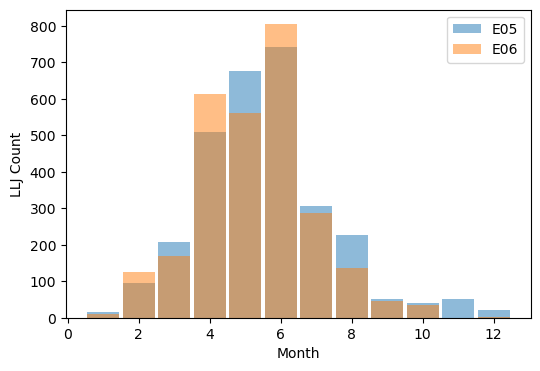

In [6]:
# seasonality plots
fig = plt.figure(figsize=(6,4))
jet_daysE05 = lidarE05['datetime'].data[jet_idE05['is_jet'].data]
jet_daysE06 = lidarE06['datetime'].data[jet_idE06['is_jet'].data]
jet_months5 = np.zeros_like(jet_daysE05, dtype='int8')
jet_months6 = np.zeros_like(jet_daysE05, dtype='int8')
for (i, day) in enumerate(jet_daysE05):
    mo = np.datetime_as_string(day)[5:7]
    jet_months5[i] = np.int8(mo)
for (i, day) in enumerate(jet_daysE06):
    mo = np.datetime_as_string(day)[5:7]
    jet_months6[i] = np.int8(mo)
bins = np.linspace(0.5, 12.5, 13)
plt.hist(jet_months5, bins, alpha=0.5,label='E05', rwidth=0.9)
plt.hist(jet_months6, bins, alpha=0.5,label='E06', rwidth=0.9)
plt.xlabel('Month')
plt.ylabel('LLJ Count')
plt.legend(loc='upper right')
plt.savefig('figures/fig2_MonthFrequency.png', bbox_inches='tight')


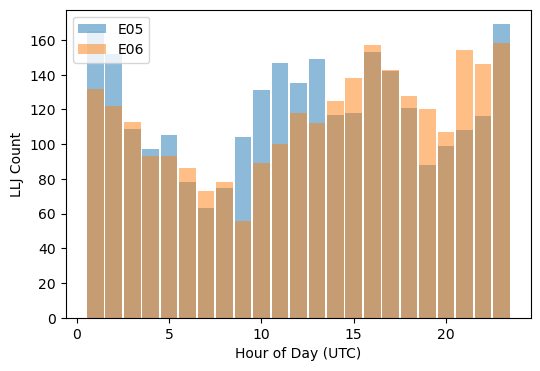

In [7]:
# time of day plots
fig = plt.figure(figsize=(6,4))
jet_hours5 = np.zeros_like(jet_daysE05, dtype='int8')
jet_hours6 = np.zeros_like(jet_daysE05, dtype='int8')
for (i, day) in enumerate(jet_daysE05):
    hr = np.datetime_as_string(day)[11:13]
    jet_hours5[i] = np.int8(hr)
for (i, day) in enumerate(jet_daysE06):
    hr = np.datetime_as_string(day)[11:13]
    jet_hours6[i] = np.int8(hr)
bins = np.linspace(0.5, 23.5, 24)
plt.hist(jet_hours5, bins, alpha=0.5,label='E05', rwidth=0.9)
plt.hist(jet_hours6, bins, alpha=0.5,label='E06', rwidth=0.9)
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('LLJ Count')
plt.legend()
plt.savefig("figures/fig3_TimeOfDayFrequency.png")

In [8]:
def find_nearest(data, x):
    diffs = np.abs([x] - np.asarray(data))
    i = np.argmin(diffs)
    return i

In [11]:
# heatmap of jet nose height and jet nose windspeed
heights_c = np.linspace(20.0, 180.0, 9)
windspeeds_c = np.linspace(0.0, 25, 11)
(hmesh, wsmesh) = np.meshgrid(heights_c, windspeeds_c)

countsE05 = np.zeros_like(hmesh)
countsE06 = np.zeros_like(hmesh)

for i in range(len(jet_idE05["t"])):
    if jet_idE05.isel(t=i)['is_jet']:
        ih = find_nearest(heights_c, jet_idE05.isel(t=i)['jet_nose_height'])
        iws = find_nearest(windspeeds_c, jet_idE05.isel(t=i)['jet_nose_speed'])
        countsE05[iws, ih] += 1

for i in range(len(jet_idE06["t"])):
    if jet_idE06.isel(t=i)['is_jet']:
        ih = find_nearest(heights_c, jet_idE06.isel(t=i)['jet_nose_height'])
        iws = find_nearest(windspeeds_c, jet_idE06.isel(t=i)['jet_nose_speed'])
        countsE06[iws, ih] += 1


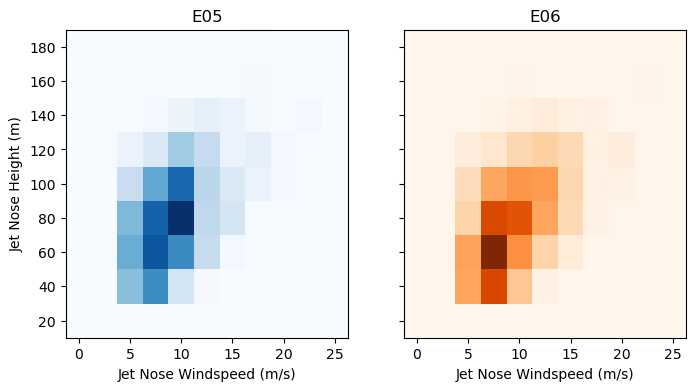

In [12]:
(fig, ax) = plt.subplots(ncols=2, sharey=True, figsize=(8,4))
ax[0].pcolormesh(wsmesh.T, hmesh.T, countsE05.T, cmap='Blues')
ax[1].pcolormesh(wsmesh.T, hmesh.T, countsE06.T, cmap='Oranges')

ax[0].set_xlabel('Jet Nose Windspeed (m/s)')
ax[0].set_ylabel('Jet Nose Height (m)')
ax[0].set_title('E05')
ax[1].set_xlabel('Jet Nose Windspeed (m/s)')
ax[1].set_title('E06')
plt.savefig('figures/fig6_NoseHeightWS.png')

## Pressure gradients

In [13]:
def find_nearest_date(date, datetimes):
    diff = np.abs(datetimes - date).data / np.timedelta64(1, 's')
    i = np.argmin(diff)
    return (i, diff[i])

In [14]:
dp_dates = np.zeros_like(lidarE06['datetime'])
dp_jets05 = np.zeros_like(jet_idE06['is_jet'])
dp_jets06 = np.zeros_like(jet_idE05['is_jet'])
dp_press = np.zeros_like(lidarE06['pressure'])
dp_temp = np.zeros_like(lidarE06['temp'])

In [16]:
j = 0
for (t, date) in enumerate(lidarE06['datetime']):
    (i, diff) = find_nearest_date(date, lidarE05['datetime'])
    if diff == 0:
        dp_dates[j] = date.data
        dp_jets06[j] = jet_idE06['is_jet'].isel(t=t)
        dp_jets05[j] = jet_idE05['is_jet'].isel(t=i)
        dp_press[j] = lidarE06['pressure'].isel(t=t) - lidarE05['pressure'].isel(t=i)
        dp_temp[j] = lidarE06['temp'].isel(t=t) - lidarE05['temp'].isel(t=i)
        j += 1
    if (j % 5000) == 0:
        print(j)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000


In [17]:
lidar_dp = xr.Dataset(
    data_vars = dict(
        delta_pressure=(["t"], dp_press[0:j]),
        delta_temp=(["t"], dp_temp[0:j]),
        is_jet05=(["t"], dp_jets05[0:j]),
        is_jet06=(["t"], dp_jets06[0:j]),
    ),
    coords=dict(
        datetime=(["t"], dp_dates[0:j]),
    )
)

In [18]:
lidar_dp.to_netcdf('LiDAR/delta_pressure_lidar_full.nc')
#lidar_dp = xr.open_dataset('LiDAR/delta_pressure_lidar_full.nc')

In [19]:
e05latlon = (39+58/60+9.4/3600, 72+43/60+.09/3600)
e06latlon = (39+32/60+48.38/3600, 73+25/60+44.01/3600)
d = gpd.geodesic(e05latlon, e06latlon).km
dx = gpd.geodesic(e05latlon, (e05latlon[0], e06latlon[1])).km
dy = gpd.geodesic(e05latlon, (e06latlon[0], e05latlon[1])).km
print(d, dx, dy)

76.97668700978139 60.844590238182754 46.91078639130137


In [20]:
e05latlon

(39.969277777777776, 72.71669166666666)

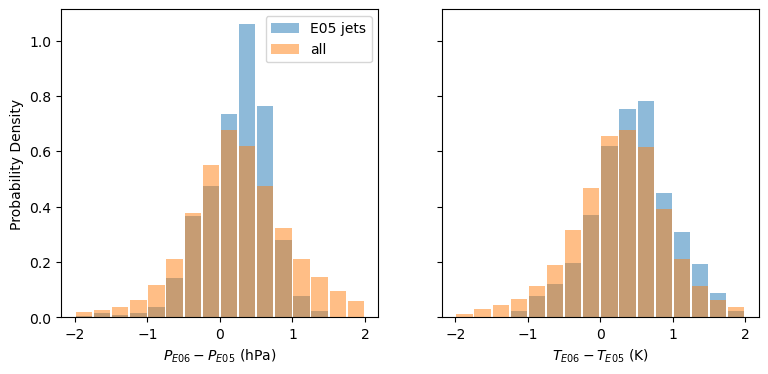

In [21]:
# delta_P plots
(fig, ax) = plt.subplots(ncols=2, sharey=True, figsize=(9,4))
jet_dp = lidar_dp['delta_pressure'][lidar_dp['is_jet05']]
all_dp = lidar_dp['delta_pressure']
bins = np.linspace(-2.0, 2.0, 17)
ax[0].hist(jet_dp, bins, alpha=0.5,label='E05 jets', rwidth=0.9, density=True, stacked=True)
ax[0].hist(all_dp, bins, alpha=0.5,label='all', rwidth=0.9, density=True, stacked=True)
ax[0].set_xlabel('$P_{E06} - P_{E05}$ (hPa)')
ax[0].set_ylabel('Probability Density')
ax[0].legend(loc='upper right')

jet_dt = lidar_dp['delta_temp'][lidar_dp['is_jet05']]
all_dt = lidar_dp['delta_temp']
bins = np.linspace(-2.0, 2.0, 17)
ax[1].hist(jet_dt, bins, alpha=0.5,label='E05 jets', rwidth=0.9, density=True, stacked=True)
ax[1].hist(all_dt, bins, alpha=0.5,label='All times', rwidth=0.9, density=True, stacked=True)
ax[1].set_xlabel('$T_{E06} - T_{E05}$ (K)')
plt.savefig('figures/fig4_DeltaTP_Distribution.png', bbox_inches='tight')


In [ ]:
# heatmap of dT and dP
dTs_c = np.linspace(-2.0, 2.0, 17)
dPs_c = np.linspace(-2.0, 2.0, 17)
(hmesh, wsmesh) = np.meshgrid(dTs_c, dPs_c)

countsE05 = np.zeros_like(hmesh)
countsAll = np.zeros_like(hmesh)

for i in range(len(lidar_dp['datetime'])):
    iT = find_nearest(dTs_c, lidar_dp.isel(t=i)['delta_temp'])
    iP = find_nearest(dPs_c, lidar_dp.isel(t=i)['delta_pressure'])
    countsAll[iT, iP] += 1
    if lidar_dp.isel(t=i)['is_jet05']:
        countsE05[iT, iP] += 1

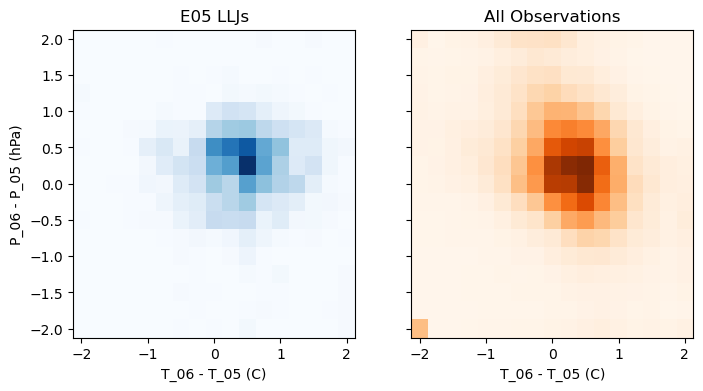

In [ ]:
(fig, ax) = plt.subplots(ncols=2, sharey=True, figsize=(8,4))
ax[0].pcolormesh(wsmesh.T, hmesh.T, countsE05.T, cmap='Blues')
ax[1].pcolormesh(wsmesh.T, hmesh.T, countsAll.T, cmap='Oranges')

ax[0].set_xlabel('T_06 - T_05 (C)')
ax[0].set_ylabel('P_06 - P_05 (hPa)')
ax[0].set_title('E05 LLJs')
ax[1].set_xlabel('T_06 - T_05 (C)')
ax[1].set_title('All Observations')
plt.savefig('figures/nan_dTdP_density.png')

## Air-sea temp difference

In [ ]:
dT_E06 = lidarE06['temp'] - lidarE06['waterT']
dT_E05 = lidarE05['temp'] - lidarE05['waterT']

dT_E06 = dT_E06.rename({'t': 'Time'})
dT_E05 = dT_E05.rename({'t': 'Time'})

In [ ]:
dTw = lidarE06['waterT'].assign_coords(t=lidarE06['datetime']) - lidarE05['waterT'].assign_coords(t=lidarE05['datetime'])
dTw = dTw.rename({'t': 'Time'})

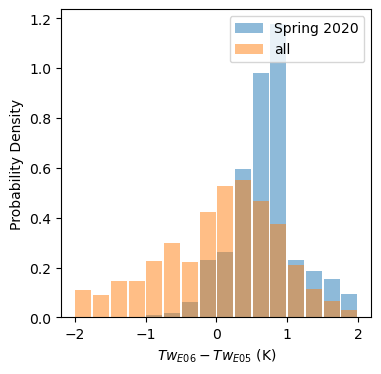

In [ ]:
# delta_Tw plots
plt.figure(figsize=(4,4))
j5 = jet_idE05.rename({'Time':'t'}).assign_coords(t=lidarE05WT['datetime'])
all_dT = dTw
spring_dT = dTw.sel(Time = slice(np.datetime64('2020-04-01'), np.datetime64('2020-07-01')))
bins = np.linspace(-2.0, 2.0, 17)
plt.hist(spring_dT, bins, alpha=0.5,label='Spring 2020', rwidth=0.9, density=True, stacked=True)
plt.hist(all_dT, bins, alpha=0.5,label='all', rwidth=0.9, density=True, stacked=True)
plt.xlabel('$Tw_{E06} - Tw_{E05}$ (K)')
plt.ylabel('Probability Density')
plt.legend(loc='upper right')

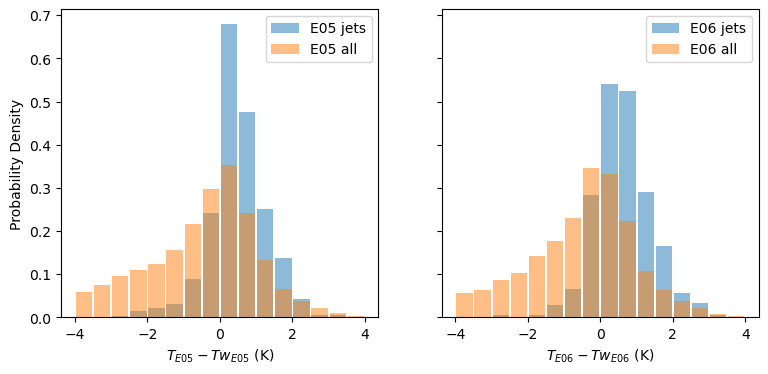

In [ ]:
# delta_T_Tw plots
(fig, ax) = plt.subplots(ncols=2, sharey=True, figsize=(9,4))
jet_dT = dT_E05[jet_idE05['is_jet'].rename(dict({'t': 'Time'}))]
all_dT = dT_E05
bins = np.linspace(-4.0, 4.0, 17)
ax[0].hist(jet_dT, bins, alpha=0.5,label='E05 jets', rwidth=0.9, density=True, stacked=True)
ax[0].hist(all_dT, bins, alpha=0.5,label='E05 all', rwidth=0.9, density=True, stacked=True)
ax[0].set_xlabel('$T_{E05} - Tw_{E05}$ (K)')
ax[0].set_ylabel('Probability Density')
ax[0].legend(loc='upper right')

jet_dT = dT_E06[jet_idE06['is_jet'].rename(dict({'t': 'Time'}))]
all_dT = dT_E06
bins = np.linspace(-4.0, 4.0, 17)
ax[1].hist(jet_dT, bins, alpha=0.5,label='E06 jets', rwidth=0.9, density=True, stacked=True)
ax[1].hist(all_dT, bins, alpha=0.5,label='E06 all', rwidth=0.9, density=True, stacked=True)
ax[1].set_xlabel('$T_{E06} - Tw_{E06}$ (K)')
ax[1].legend(loc='upper right')
plt.savefig('figures/fig5_AirSeadT.png', bbox_inches='tight')

## Other analyses not included in manuscript

In [100]:
# # heatmap of T vs time of day
# # heatmap of Tw vs time of day
# # heatmap of T vs month of year
# # heatmap of Tw vs month of year
# # heatmap of differences vs month / time
Ta_c = np.linspace(-6.0, 28.0, 12)
Tw_c = np.linspace(-6.0, 28.0, 12)
dT_c = np.linspace(-4.0, 4.0, 12)
months = np.linspace(1, 12, 12)
hours = np.linspace(1, 23, 12)

(T_m_mesh, monthmesh) = np.meshgrid(Ta_c, months)
(dT_m_mesh, monthmesh) = np.meshgrid(dT_c, months)

(T_h_mesh, hourmesh) = np.meshgrid(Ta_c, hours)
(dT_h_mesh, hourmesh) = np.meshgrid(dT_c, hours)

T_m_countsE05 = np.zeros_like(T_m_mesh)
T_m_countsAll = np.zeros_like(T_m_mesh)
Tw_m_countsE05 = np.zeros_like(T_m_mesh)
Tw_m_countsAll = np.zeros_like(T_m_mesh)
dT_m_countsE05 = np.zeros_like(T_m_mesh)
dT_m_countsAll = np.zeros_like(T_m_mesh)

T_h_countsE05 = np.zeros_like(T_h_mesh)
T_h_countsAll = np.zeros_like(T_h_mesh)
Tw_h_countsE05 = np.zeros_like(T_h_mesh)
Tw_h_countsAll = np.zeros_like(T_h_mesh)
dT_h_countsE05 = np.zeros_like(T_h_mesh)
dT_h_countsAll = np.zeros_like(T_h_mesh)

for i in range(len(lidarE05WT['datetime'])):
    iT = find_nearest(Ta_c, lidarE05WT.isel(t=i)['temp'])
    iTw = find_nearest(Tw_c, lidarE05WT.isel(t=i)['waterT'])
    idT = find_nearest(dT_c, lidarE05WT.isel(t=i)['temp'] - lidarE05WT.isel(t=i)['waterT'])
    imo = find_nearest(months, int(str(lidarE05WT['datetime'].isel(t=i).data)[5:7]))
    ihr = find_nearest(hours, int(str(lidarE05WT['datetime'].isel(t=i).data)[11:13]))
    T_m_countsAll[iT, imo] += 1
    Tw_m_countsAll[iTw, imo] += 1
    dT_m_countsAll[idT, imo] += 1
    T_h_countsAll[iT, ihr] += 1
    Tw_h_countsAll[iTw, ihr] += 1
    dT_h_countsAll[idT, ihr] += 1
    if jet_idE05.isel(Time=i)['is_jet']:
        T_m_countsE05[iT, imo] += 1
        Tw_m_countsE05[iTw, imo] += 1
        dT_m_countsE05[idT, imo] += 1
        T_h_countsE05[iT, ihr] += 1
        Tw_h_countsE05[iTw, ihr] += 1
        dT_h_countsE05[idT, ihr] += 1

In [112]:
T_h_countsE05.sum(axis=0)

array([520., 206., 183., 138., 235., 282., 266., 271., 263., 187., 224.,
       169.])

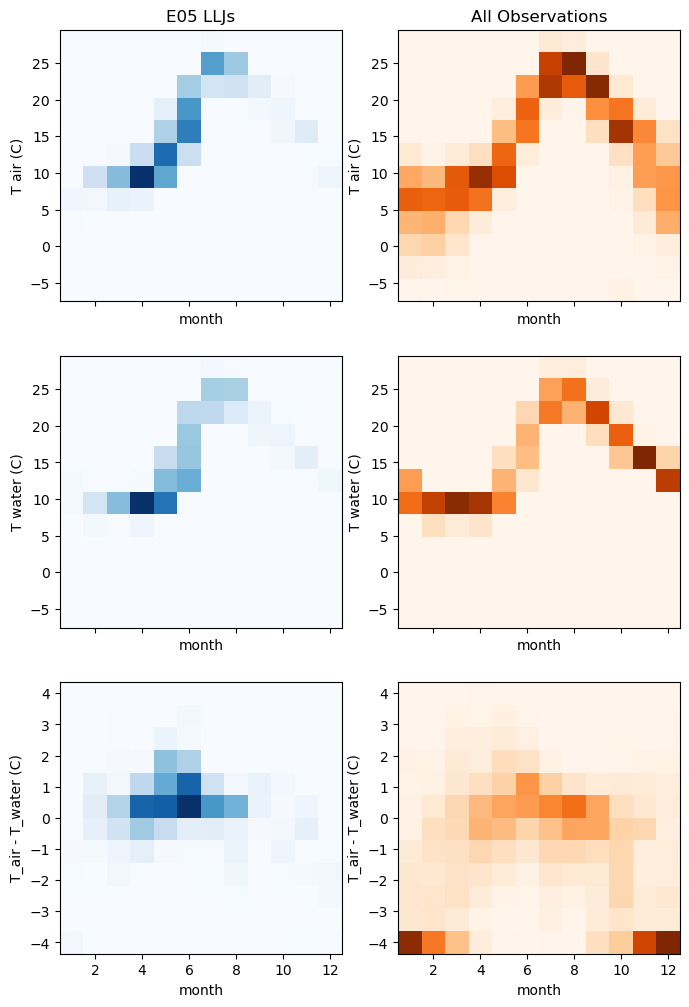

In [103]:
(fig, ax) = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(8,12))
ax[0][0].pcolormesh(monthmesh, T_m_mesh, T_m_countsE05.T, cmap='Blues')
ax[0][1].pcolormesh(monthmesh, T_m_mesh, T_m_countsAll.T, cmap='Oranges')
ax[1][0].pcolormesh(monthmesh, T_m_mesh, Tw_m_countsE05.T, cmap='Blues')
ax[1][1].pcolormesh(monthmesh, T_m_mesh, Tw_m_countsAll.T, cmap='Oranges')
ax[2][0].pcolormesh(monthmesh, dT_m_mesh, dT_m_countsE05.T, cmap='Blues')
ax[2][1].pcolormesh(monthmesh, dT_m_mesh, dT_m_countsAll.T, cmap='Oranges')

ax[0][0].set_ylabel('T air (C)')
ax[0][0].set_xlabel('month')
ax[0][1].set_ylabel('T air (C)')
ax[0][1].set_xlabel('month')

ax[1][0].set_ylabel('T water (C)')
ax[1][0].set_xlabel('month')
ax[1][1].set_ylabel('T water (C)')
ax[1][1].set_xlabel('month')

ax[2][0].set_ylabel('T_air - T_water (C)')
ax[2][0].set_xlabel('month')
ax[2][1].set_ylabel('T_air - T_water (C)')
ax[2][1].set_xlabel('month')

ax[0][0].set_title('E05 LLJs')
ax[0][1].set_title('All Observations')
plt.savefig('figures/airSeadT_seasonality.png')

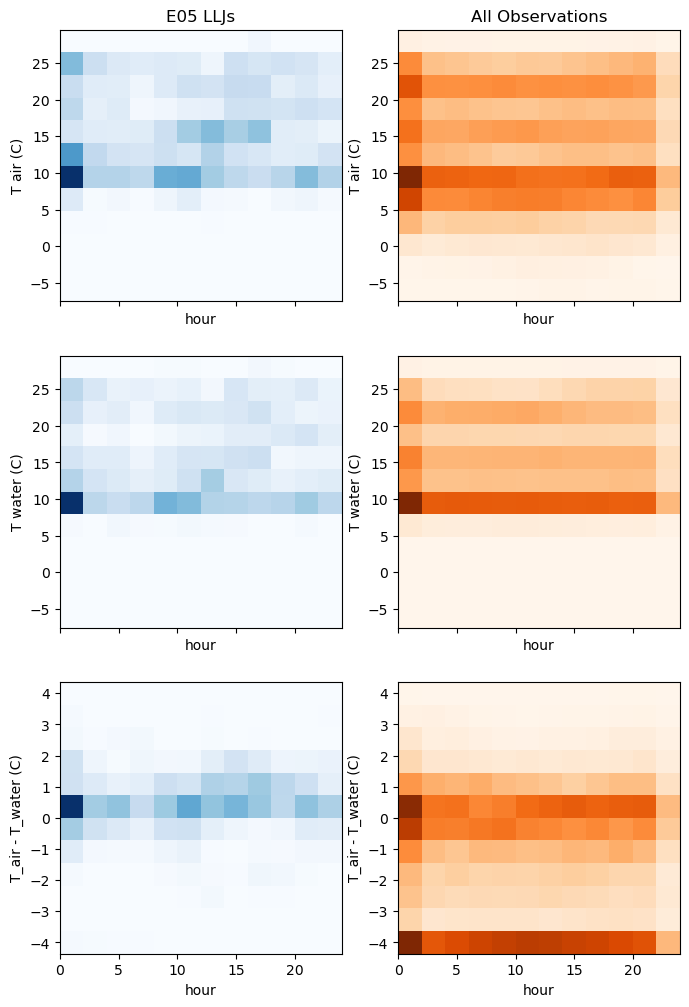

In [104]:
(fig, ax) = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(8,12))
ax[0][0].pcolormesh(hourmesh, T_h_mesh, T_h_countsE05.T, cmap='Blues')
ax[0][1].pcolormesh(hourmesh, T_h_mesh, T_h_countsAll.T, cmap='Oranges')
ax[1][0].pcolormesh(hourmesh, T_h_mesh, Tw_h_countsE05.T, cmap='Blues')
ax[1][1].pcolormesh(hourmesh, T_h_mesh, Tw_h_countsAll.T, cmap='Oranges')
ax[2][0].pcolormesh(hourmesh, dT_h_mesh, dT_h_countsE05.T, cmap='Blues')
ax[2][1].pcolormesh(hourmesh, dT_h_mesh, dT_h_countsAll.T, cmap='Oranges')

ax[0][0].set_ylabel('T air (C)')
ax[0][0].set_xlabel('hour')
ax[0][1].set_ylabel('T air (C)')
ax[0][1].set_xlabel('hour')

ax[1][0].set_ylabel('T water (C)')
ax[1][0].set_xlabel('hour')
ax[1][1].set_ylabel('T water (C)')
ax[1][1].set_xlabel('hour')

ax[2][0].set_ylabel('T_air - T_water (C)')
ax[2][0].set_xlabel('hour')
ax[2][1].set_ylabel('T_air - T_water (C)')
ax[2][1].set_xlabel('hour')

ax[0][0].set_title('E05 LLJs')
ax[0][1].set_title('All Observations')
plt.savefig('figures/airSeadT_diurnal.png')